In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Model
from keras import backend as K
from tensorflow.keras.metrics import AUC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [229]:
#Train dataset creation
num_steps = 24
num_features_t = 35
timeseries_train_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/train/timeseries.csv')
flat_train_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/train/flat.csv')
labels_train_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/train/labels.csv')
arr_timeseries_train = timeseries_train_df.values
x_train_reshape = np.reshape(arr_timeseries_train, (-1, num_steps, num_features_t))
x_train_reshape = x_train_reshape[:, :, 1:] # Removed patient column

flat_train_df = flat_train_df.fillna(flat_train_df.mean())
x_train_over_static = flat_train_df.iloc[:, 1:]

y_train = labels_train_df['actualhospitalmortality']
#y_train = np.expand_dims(y_train, axis=1) # adding 1 to the second dimension
#y_train_reshape = np.reshape(y_train, (-1, num_steps))
#y_train_reshape.shape

In [230]:
#Test dataset creation
num_steps = 24
num_features_t = 35
timeseries_test_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/test/timeseries.csv')
flat_test_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/test/flat.csv')
labels_test_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/test/labels.csv')
arr_timeseries_test = timeseries_test_df.values
x_test_reshape = np.reshape(arr_timeseries_test, (-1, num_steps, num_features_t))
x_test_reshape = x_test_reshape[:, :, 1:] # Removed patient column

flat_test_df = flat_test_df.fillna(flat_train_df.mean())
x_test_over_static = flat_test_df.iloc[:, 1:]

y_test = labels_test_df['actualhospitalmortality']
#y_val = np.expand_dims(y_val, axis=1) # adding 1 to the second dimension
#y_val_reshape = np.reshape(y_val, (-1, num_steps))
#x_val_over_static.shape


In [231]:
#Validation dataset creation
num_steps = 24
num_features_t = 35
timeseries_val_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/val/timeseries.csv')
flat_val_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/val/flat.csv')
labels_val_df = pd.read_csv('/media/nasim/31c299f0-f952-4032-9bd8-001b141183e0/ML-Libraries-Graph-Database-Neo4j/PyG-Neo4j/app/eICU_data/val/labels.csv')
arr_timeseries_val = timeseries_val_df.values
x_val_reshape = np.reshape(arr_timeseries_val, (-1, num_steps, num_features_t))
x_val_reshape = x_val_reshape[:, :, 1:] # Removed patient column

flat_val_df = flat_val_df.fillna(flat_train_df.mean())
x_val_over_static = flat_val_df.iloc[:, 1:]

y_val = labels_val_df['actualhospitalmortality']
#y_val = np.expand_dims(y_val, axis=1) # adding 1 to the second dimension
#y_val_reshape = np.reshape(y_val, (-1, num_steps))
#x_val_over_static.shape
y_val.shape

(13369,)

In [232]:
# Define timesteps and the number of featuresn_timesteps = 24
n_timesteps = 24
n_features = 34
n_outputs = 1
epochs = 5
batch_size = 64
verbose = False

In [233]:
# Define input layer
recurrent_input = Input(shape=(n_timesteps,n_features),name="TIMESERIES_INPUT")

static_input = Input(shape=(x_train_over_static.shape[1], ),name="STATIC_INPUT")

In [234]:
# layer - 1
rec_layer_one = Bidirectional(LSTM(128, kernel_regularizer=regularizers.L2(0.01), recurrent_regularizer=regularizers.L2(0.01),return_sequences=True),name ="BIDIRECTIONAL_LAYER_1")(recurrent_input)
rec_layer_one = Dropout(0.1,name ="DROPOUT_LAYER_1")(rec_layer_one)
# layer - 2
rec_layer_two = Bidirectional(LSTM(64, kernel_regularizer=regularizers.L2(0.01), recurrent_regularizer=regularizers.L2(0.01)),name ="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
rec_layer_two = Dropout(0.1,name ="DROPOUT_LAYER_2")(rec_layer_two)
# SLP Layers
static_layer_one = Dense(64,  kernel_regularizer=regularizers.L2(0.001),  activation='relu',name="DENSE_LAYER_1")(static_input)

In [235]:
# Combine layers - RNN + SLP
combined = Concatenate(axis= 1,name = "CONCATENATED_TIMESERIES_STATIC")([rec_layer_two,static_layer_one])
combined_dense_two = Dense(64, activation='relu',name="DENSE_LAYER_2")(combined)
output = Dense(n_outputs,activation='sigmoid',name="OUTPUT_LAYER")(combined_dense_two)

In [236]:
# Compile ModeL
model = Model(inputs=[recurrent_input,static_input],outputs=[output])

In [237]:
# Define metrics for evaluating the model - recall, precision and f1-score
def recall_m(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + np.epsilon())
    return recall                     

In [238]:
def precision_m(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + np.epsilon())
    return precision

In [239]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+np.epsilon()))

In [240]:
#Calculate confusion matrix
def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN
    return tn/n

In [241]:
# binary cross entropy loss
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC(curve="ROC"), AUC(curve="PR"), TP, TN, FP, FN])

In [242]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 24, 34)]     0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (Bidirec  (None, 24, 256)     166912      ['TIMESERIES_INPUT[0][0]']       
 tional)                                                                                          
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 24, 256)      0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (Bidirec  (None, 128)         164352      ['DROPOUT_LAYER_1[0][0]'] 

In [243]:
history = model.fit([np.asarray(x_train_reshape).astype('float32'), np.asarray(x_train_over_static).astype('float32')], y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=([np.asarray(x_val_reshape).astype('float32'), np.asarray(x_val_over_static).astype('float32')], y_val))

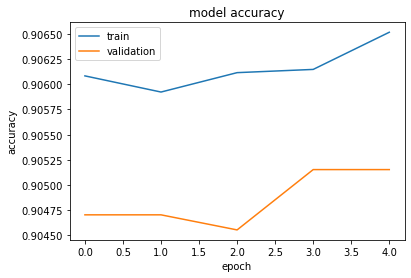

In [244]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

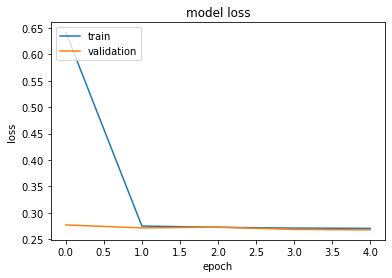

In [245]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [246]:
loss, accuracy, AUROC, AUPRC, TP, TN, FP, FN = model.evaluate([np.asarray(x_test_reshape).astype('float32'),np.asarray(x_test_over_static).astype('float32')], y_test, batch_size=batch_size, verbose=0)

418/418 [==============================] - 5s 9ms/step
[0 0 0 ... 0 0 0]


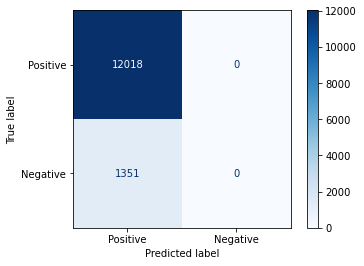

In [247]:
#y_pred = model.predict_classes([np.asarray(x_test_reshape).astype('float32'),np.asarray(x_test_over_static).astype('float32')])

y_pred = np.argmax(model.predict([np.asarray(x_test_reshape).astype('float32'),np.asarray(x_test_over_static).astype('float32')]), axis=1)

print(y_pred)

cm = confusion_matrix(y_test, y_pred)
labels = ["Positive", "Negative"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [248]:
print("Accuracy:{} AUROC:{} AUPRC:{} TP:{} TN:{} FP:{} FN:{}".format(accuracy, AUROC, AUPRC, TP, TN, FP, FN))

Accuracy:0.8991697430610657 AUROC:0.7839875817298889 AUPRC:0.3286448121070862 TP:0.00029904305119998753 TN:0.8988316059112549 FP:7.476076279999688e-05 FN:0.10079456120729446
